<img src="https://www.uzhnu.edu.ua/uploads/news/20200404_1320_covid-19-2-1140x450.jpg" width="1000px"> 
# Simulation of the spread of COVID-19 indoors

**by team GORNYAKI (Tsepa Oleksii and Samoshin Andriy [Ukraine, KPI, IASA])**

**The task** is to create a model of virus spread among people indoors based on some parameters and to determine the confidence intervals for the mathematical expectations of each category of people at time t with a confidence level of 95%.

**Input parameters:**
* Time when a person is infected but not contagious - latency period (tabular data)
* Time from the beginning of contagion to the end of contagion - the period of active infection (tabular data)
* Distribution of probabilities of death during the period of active infection (tabular data)
* The value of the probability of becoming infected from an already infected person

**Practical value:** provided that the input parameters reflect the real situation, we can simulate the situation when a family member "brought" the virus home, and understand how critical the consequences can be depending on the number of family members and quarantine measures within the family.

# Description and substantiation of the approach to model construction
We model the dynamics of the virus in the family using the Monte Carlo method. This method is based on a large number of computer simulations based on input parameters. Using this method and the law of large numbers, we obtain the approximate value of the mathematical expectation, since n is the number of simulations, a large number.
<img src="https://github.com/imgremlin/Photos/blob/master/Screenshot%20(22).png?raw=true" width="220px">
We do not know the distribution of each group of people, but according to the central limit theorem, the distribution of the sample mean is approximately normal (because the number experiments large enough n>100) with an unknown standard deviation. Therefore, to construct confidence intervals, we use the formula:
<img src="https://github.com/imgremlin/Photos/blob/master/Screenshot%20(23).png?raw=true" width="115px">
where 𝑋̅ is the sample mean, 𝑐 is the tabular value of the t-distribution corresponding to 1 − 𝛼/2, with n-1 degrees of freedom, 𝑆𝑛 is the sample standard deviation.
As a result, we have point estimates for mathematical expectations and confidence intervals.
The value that is added and subtracted from the sample mean is equal to half the length of the interval.
<img src="https://github.com/imgremlin/Photos/blob/master/Screenshot%20(24).png?raw=true" width="135px">
Solving the equation with respect to n, we obtain the following:
<img src="https://github.com/imgremlin/Photos/blob/master/Screenshot%20(26).png?raw=true" width="150px">
We use this formula to determine the required number of experiments for a given length of confidence intervals.

**The initial input data:**
we believe that the virus does not change over time, so we use estimates of virus parameters that have already been made by scientists before modeling. The only thing that can change for each family is the extent to which it is quarantined (if everyone is sitting in their own rooms, the probability of getting sick from another family member is much lower). Also, the model does not take into account the possibility of infection from the outside (shops, churches, etc.).


When we know all the parameters, **model predicts** :
* increase and decrease in morbidity
* approximate peak time
* the number of people in each category at a particular time

# Implementation
**Features of the model:** does not involve recurrent diseases; cured and healthy are counted separately; if the latent period (tabular data) has passed, and the person has not yet passed to active, it passes automatically

**Input data**
* P_inf - likelihood of becoming infected from an already infected person
* P_latent - probability distribution to go from latent to active period of the disease
* P_active - probability distribution to get out of the active phase of the disease (recover or die)
* P_die - розподіл ймовірності смерті хворої людини of a sick person to die
* N - number of people
* n_days - number of days for simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats
from math import sqrt

P_inf = 0.2

N = 10
n_days = 90

P_latent = [0.01, 0.03, 0.05, 0.2, 0.6, 0.1, 0.01]
P_active = [0.005, 0.02, 0.04, 0.015, 0.02, 0.035, 0.15, 0.5, 0.09, 0.04, 0.04, 0.02, 0.02, 0.005]
P_die = [0.01, 0.01, 0.03, 0.05, 0.07, 0.12, 0.18, 0.2, 0.1, 0.07, 0.05, 0.05, 0.04, 0.02]

x_die = [x+1 for x in range(len(P_die))]
x_latent = [x+1 for x in range(len(P_latent))]
x_active = [x+1 for x in range(len(P_active))]

latent_series = pd.DataFrame({'Day': x_latent, 'Prob': P_latent}).set_index('Day')
active_series = pd.DataFrame({'Day': x_active, 'Prob': P_active}).set_index('Day')
die_series = pd.DataFrame({'Day': x_die, 'Prob': P_die}).set_index('Day')

**Internal functions of the program:**
* stats_graph - function for plotting
* conf_interval_graph - illustration of confidence intervals
* simulation - simulation of a certain number of experiments
* stats_array_by_case - calculation of the sample mean and deviation for each day
* conf_interval - calculation of confidence intervals
* conf_find_number - counting the number of experiments for a given interval length

**Internal designations:**
* he := healthy person (not sick)
* de := dead person
* l{i} := latent person on {i} day of this period of illness
* a{i} := actively contagious person on {i} days of this period of illness
* re := the person recovered and gained immunity

In [2]:
def simulation(number):
    #create a daily information table for each family member
    global family_model
    family_model = pd.DataFrame({'Day': [x for x in range(n_days+1)]}).set_index('Day')
    
    for n in range(N):
        family_model[f'N{n+1}'] = 'he'

    #initialization of the first family member in the latent period
    start_chlen = np.random.randint(N)
    all_family = list(family_model.columns)
    
    family_model.iloc[0, start_chlen] = 'l0'
    
    #associated counters and arrays for each type of family member
    n_he = N-1
    n_he_array = [n_he]
    
    global all_h, all_de, all_a, all_re, all_l
    all_h = all_family.copy()
    all_h.remove(family_model.columns.values[start_chlen])
    
    n_de = n_a = n_re = 0
    n_de_acc = n_a_acc = 0
    all_de = list()
    all_a = list()
    all_re = list()
    
    n_re_array = [0]
    n_de_array = [0] 
    n_a_array = [0]
    n_de_acc_array = [0] 
    n_a_acc_array = [0]
    
    n_l = n_l_acc = 1
    n_l_array = [n_l]
    n_l_acc_array = [n_l_acc]
    all_l = list()
    all_l.append(family_model.columns.values[start_chlen])
    
    #experiment simulation
    for day in range(0, n_days, 1):
        for user in range(N):
            cur = family_model.iloc[day, user]
            
            #latent
            if re.findall(r'\w', cur)[0]=='l':
                id = int(re.findall(r'\d+', cur)[0])
                check_nextday = np.random.rand()
                if id<len(P_latent):
                    #every day a new random value and check
                    #if the random value is greater than the value in the series, then the next day the latent phase continues
                    if check_nextday >= latent_series.Prob.iloc[id]:
                        family_model.iloc[day+1, user] = f'l{id+1}'
                    #otherwise goes into the active phase
                    else:
                        family_model.iloc[day+1, user] = 'a1'
                        n_l = n_l - 1
                        all_l.remove(family_model.columns.values[user])
                        n_a = n_a + 1
                        n_a_acc = n_a_acc + 1
                        all_a.append(family_model.columns.values[user])
                #if all the days have passed, then we ourselves determine that the person goes into the active phase       
                else:
                    family_model.iloc[day+1, user] = 'a1'
                    n_l = n_l - 1
                    all_l.remove(family_model.columns.values[user])
                    n_a = n_a + 1
                    n_a_acc = n_a_acc + 1
                    all_a.append(family_model.columns.values[user])
            
            #active
            if re.findall(r'\w', cur)[0]=='a':
                id = int(re.findall(r'\d+', cur)[0])
                check_nextday = np.random.rand()
                check_die = np.random.rand()
                
                #every day a new random value and check
                #if the random value is greater than the value in the series, then the next day the latent phase continues
                if id<len(P_active):
                    if check_nextday >= active_series.Prob.iloc[id]:
                        family_model.iloc[day+1, user] = f'a{id+1}'
                    #otherwise either dies or recovered
                    else:
                        if check_die < die_series.Prob.iloc[id]:
                            family_model.iloc[day+1:, user] = 'de'
                            n_a = n_a - 1
                            all_a.remove(family_model.columns.values[user])
                            n_de = n_de + 1
                            n_de_acc = n_de_acc + 1
                            all_de.append(family_model.columns.values[user])
                        else:
                            family_model.iloc[day+1:, user] = 're'
                            n_a = n_a - 1
                            all_a.remove(family_model.columns.values[user])
                            n_re = n_re + 1
                            all_re.append(family_model.columns.values[user])
                #the period of the active phase has passed and the person has not died, so he recovered      
                else:
                    family_model.iloc[day+1:, user] = 're'
                    n_a = n_a - 1
                    all_a.remove(family_model.columns.values[user])
                    n_re = n_re + 1
                    all_re.append(family_model.columns.values[user])
                        
                        
                #the generation of new infections
                check_inf = np.random.rand()
                #check whether someone can be infected
                if len(all_h)!=0: 
                    
                    if check_inf < (1-(1-P_inf)**(n_a)):
                        #choose whom to infect
                        select_victim = np.random.randint(n_he)
                        victim = all_h[select_victim]
                        family_model[victim].iloc[day+1]='l1'
                        all_l.append(victim)
                        n_l = n_l + 1
                        n_l_acc = n_l_acc + 1
                        all_h.remove(victim)
                        n_he = n_he - 1
        #update the values of arrays at the end of each day         
        n_l_array.append(n_l)
        n_l_acc_array.append(n_l_acc)
        n_he_array.append(n_he)
        n_de_array.append(n_de)
        n_de_acc_array.append(n_de_acc)
        n_re_array.append(n_re)
        n_a_array.append(n_a)
        n_a_acc_array.append(n_a_acc)

    return n_a_array, n_he_array, n_l_array, n_de_array, n_re_array, n_a_acc_array, n_l_acc_array, n_de_acc_array

We simulate our experiment 100 times (the more we set the value, the more accurate the result will be, but we sacrifice time)

The probabilities of all events in the experiment are generated as the probability of success or failure:
<img src="https://github.com/imgremlin/Photos/blob/master/Screenshot%20(25).png?raw=true" width="250px">

In [3]:
times=100
sim = []

for id in range(times):
    sim.append(simulation(id+1))

In [4]:
def stats_array_by_case(array, days, n, case):
    mean_case_by_days = []
    std_case_by_days = []
    for day in range(days):
        array_day = []
        for i in range(n):
            array_day.append(array[i][case][day])
        array_day = np.array(array_day)
        mean_case_by_days.append(array_day.mean())
        std_case_by_days.append(array_day.std(ddof=1))
        
    return np.array(mean_case_by_days), np.array(std_case_by_days)

In [5]:
mean_a_days, std_a_days = stats_array_by_case(sim, n_days, times, 0)
mean_he_days, std_he_days = stats_array_by_case(sim, n_days, times, 1)
mean_l_days, std_l_days = stats_array_by_case(sim, n_days, times, 2)
mean_de_days, std_de_days = stats_array_by_case(sim, n_days, times, 3)
mean_re_days, std_re_days = stats_array_by_case(sim, n_days, times, 4)
mean_a_acc_days, std_a_acc_days = stats_array_by_case(sim, n_days, times, 5)
mean_l_acc_days, std_l_acc_days = stats_array_by_case(sim, n_days, times, 6)
mean_de_acc_days, std_de_acc_days = stats_array_by_case(sim, n_days, times, 7)

At the end program shows several plots - the dynamics of the next n_days days since the first case of coronavirus in the family (without and with accumulation), the standard deviation of each day and a graphical illustration of confidence intervals.

**Plots explanation:**
* The green curve shows the number of healthy people.
* Orange curve - the number of people with the disease in the latent period.
* Red curve - the number of people with the disease during the period of active infection.
* Black curve - the number of deaths.
* Blue curve - the number of people who were cured.

In [6]:
def stats_graph(n_a, n_he, n_l, n_de, n_re, name, acc, ind):
    accomodation = 'without accumulation'
    indent = '(expected value)'
    if (acc==1):
        accomodation = 'with accumulation'
    if (ind==1):
        indent = '(standard deviation)'
    plt.grid(alpha=0.4)
    plt.plot(n_a, c='r', label='Active inf case')    
    plt.plot(n_he, c='g', label='Healthy case')
    plt.plot(n_l, c='y', label='Latention case')
    plt.plot(n_de, c='k', label='Die case')
    plt.plot(n_re, c='c', label='Recover case')
    plt.title(name+f'\n (case {accomodation})')
    plt.xlabel('Days after first infection')
    plt.ylabel('Number of members')
    plt.legend(loc = 'best')
    plt.savefig(f"lineplot {accomodation} {indent}.png") 
    plt.show()

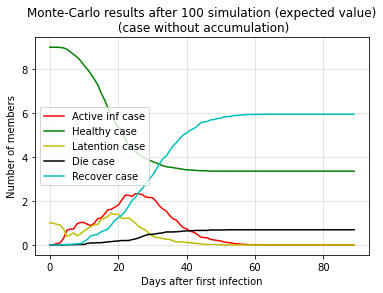

In [7]:
stats_graph(mean_a_days, mean_he_days, mean_l_days, mean_de_days, mean_re_days, 'Monte-Carlo results after '+str(times)+' simulation (expected value)', 0, 0)

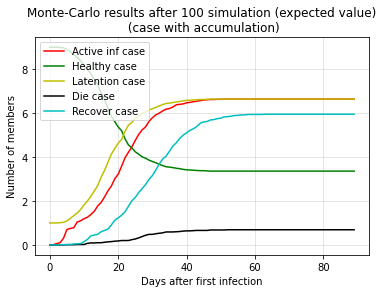

In [8]:
stats_graph(mean_a_acc_days, mean_he_days, mean_l_acc_days, mean_de_acc_days, mean_re_days, 'Monte-Carlo results after '+str(times)+' simulation (expected value)', 1, 0)

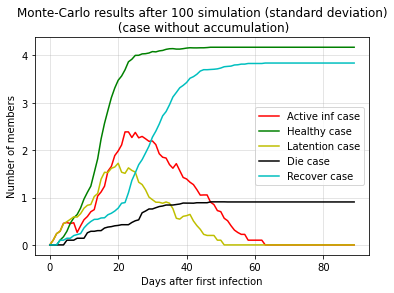

In [9]:
stats_graph(std_a_days, std_he_days, std_l_days, std_de_days, std_re_days, 'Monte-Carlo results after '+str(times)+' simulation (standard deviation)', 0, 1)

In [10]:
df = pd.DataFrame({'Day': [x+1 for x in range(n_days)],
                       'Healthy cases': mean_he_days,
                       'Latent cases': mean_l_days,
                       'Active cases': mean_a_days,
                       'Die cases': mean_de_days,
                       'Recover cases': mean_re_days})
df.to_csv('Expected value without accomodation.csv', index=False)

df_acc = pd.DataFrame({'Day': [x+1 for x in range(n_days)],
                       'Healthy cases': mean_he_days,
                       'Latent cases': mean_l_acc_days,
                       'Active cases': mean_a_acc_days,
                       'Die cases': mean_de_acc_days,
                       'Recover cases': mean_re_days})
df_acc.to_csv('Expected value with accomodation.csv', index=False)

# Estimating using the t-interval

And also calculation of **confidence intervals:**
* Enter the day number for which you want to see statistics
* Enter the (1-p) of confidence interval

In [11]:
def conf_interval(mean, std_mean, dof, alpha):
    tcrit = stats.t.ppf(1 - alpha / 2., dof)
    lower = mean - tcrit * std_mean/sqrt(dof)
    upper = mean + tcrit * std_mean/sqrt(dof)
    return round(lower, 5), round(upper, 5), tcrit

In [12]:
day_check=15
print('Enter the day number for which you want to see statistics: ', day_check)

eps=0.05
print('Enter the (1-p) of confidence interval: ', eps)
    
print(f'\nActual Active case mean in {day_check} day: ', mean_a_days[day_check])
t_actual = conf_interval(mean_a_days[day_check], std_a_days[day_check]/sqrt(len(std_a_days)), times-1, eps)
print(f'Active case mean {int((1-eps)*100)}% confidence interval in {day_check} day: ', t_actual[:2])
    
print(f'\nActual Heath case mean in {day_check} day: ', mean_he_days[day_check])
t_heath = conf_interval(mean_he_days[day_check], std_he_days[day_check]/sqrt(len(std_a_days)), times-1, eps)
print(f'Heath case mean {int((1-eps)*100)}% confidence interval in {day_check} day: ', t_heath[:2])

print(f'\nActual Latent case mean in {day_check} day: ', mean_l_days[day_check])
t_latent = conf_interval(mean_l_days[day_check], std_l_days[day_check]/sqrt(len(std_a_days)), times-1, eps)
print(f'Latent case mean {int((1-eps)*100)}% confidence interval in {day_check} day: ', t_latent[:2])

print(f'\nActual Die case mean in {day_check} day: ', mean_de_days[day_check])
t_die = conf_interval(mean_de_days[day_check], std_de_days[day_check]/sqrt(len(std_a_days)), times-1, eps)
print(f'Die case mean {int((1-eps)*100)}% confidence interval in {day_check} day: ', t_die[:2])

print(f'\nActual Recover case mean in {day_check} day: ', mean_re_days[day_check])
t_recover = conf_interval(mean_re_days[day_check], std_re_days[day_check]/sqrt(len(std_a_days)), times-1, eps)
print(f'Recover case mean {int((1-eps)*100)}% confidence interval in {day_check} day: ', t_recover[:2])

Enter the day number for which you want to see statistics:  15
Enter the (1-p) of confidence interval:  0.05

Actual Active case mean in 15 day:  1.23
Active case mean 95% confidence interval in 15 day:  (1.2065, 1.2535)

Actual Heath case mean in 15 day:  6.92
Heath case mean 95% confidence interval in 15 day:  (6.87298, 6.96702)

Actual Latent case mean in 15 day:  1.15
Latent case mean 95% confidence interval in 15 day:  (1.12082, 1.17918)

Actual Die case mean in 15 day:  0.1
Die case mean 95% confidence interval in 15 day:  (0.09366, 0.10634)

Actual Recover case mean in 15 day:  0.6
Recover case mean 95% confidence interval in 15 day:  (0.58805, 0.61195)


In [13]:
def conf_interval_graph(t_a, t_he, t_l, t_de, t_re, day, n_a, n_he, n_l, n_de, n_re, name):
    
    plt.grid(alpha=0.4)
    plt.plot(n_a, c='r', label='Active inf case')
    plt.plot(day, t_a[0], marker = 6, markersize=5, c='r')
    plt.plot(day, t_a[1], marker = 7, markersize=5, c='r')    
    plt.plot(n_he, c='g', label='Healthy case')
    plt.plot(day, t_he[0], marker = 6, markersize=5, c='g')
    plt.plot(day, t_he[1], marker = 7, markersize=5, c='g')
    plt.plot(n_l, c='y', label='Latention case')
    plt.plot(day, t_l[0], marker = 6, markersize=5, c='y')
    plt.plot(day, t_l[1], marker = 7, markersize=5, c='y')
    plt.plot(n_de, c='k', label='Die case')
    plt.plot(day, t_de[0], marker = 6, markersize=5, c='k')
    plt.plot(day, t_de[1], marker = 7, markersize=5, c='k')
    plt.plot(n_re, c='c', label='Recover case')
    plt.plot(day, t_re[0], marker = 6, markersize=5, c='c')
    plt.plot(day, t_re[1], marker = 7, markersize=5, c='c')
    
    plt.xlim(day-day/2, day+(n_days-day)/4)
    plt.title(name)
    plt.xlabel('Days after first infection')
    plt.ylabel('Number of members')
    plt.legend(loc = 'best')
    plt.savefig("conf_interval.png")
    plt.show()

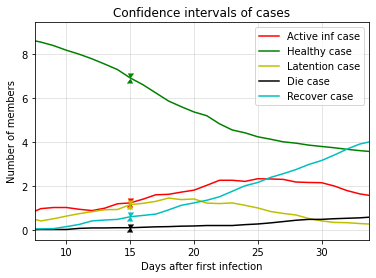

In [14]:
conf_interval_graph(t_actual, t_heath, t_latent, t_die, t_recover, day_check, mean_a_days, mean_he_days, mean_l_days, mean_de_days, mean_re_days, 'Confidence intervals of cases')

In [15]:
def conf_find_number(mean, std_mean, tcrit, eps):
    n = (tcrit*std_mean/eps)**2
    return int(n)+1

* Enter the day number for which you want to calculate the intervals
* And also (1-level of trust).

We are looking for the number of tests to achieve the size of the interval (specify the average, std, the definition of the quantile, the size of the half-interval)

In [16]:
e=0.01
print('Enter the length of half-interval: ',e)

n_actual = conf_find_number(mean_a_days[day_check], std_a_days[day_check], t_actual[2], e)
print(f'Number of exp for Active case in {day_check} day with {2*e} length interval: ', n_actual)

n_health = conf_find_number(mean_he_days[day_check], std_he_days[day_check], t_heath[2], e)
print(f'Number of exp for Health case in {day_check} day with {2*e} length interval: ', n_health)

n_latent = conf_find_number(mean_l_days[day_check], std_l_days[day_check], t_latent[2], e)
print(f'Number of exp for Latent case in {day_check} day with {2*e} length interval: ', n_latent)

n_die = conf_find_number(mean_de_days[day_check], std_de_days[day_check], t_die[2], e)
print(f'Number of exp for Die case in {day_check} day with {2*e} length interval: ', n_die)

n_recover = conf_find_number(mean_re_days[day_check], std_re_days[day_check], t_recover[2], e)
print(f'Number of exp for Recover case in {day_check} day with {2*e} length interval: ', n_recover)

Enter the length of half-interval:  0.01
Number of exp for Active case in 15 day with 0.02 length interval:  49199
Number of exp for Health case in 15 day with 0.02 length interval:  197000
Number of exp for Latent case in 15 day with 0.02 length interval:  75860
Number of exp for Die case in 15 day with 0.02 length interval:  3580
Number of exp for Recover case in 15 day with 0.02 length interval:  12727


# Conclusions
* The study allows, depending on the input parameters to simulate the situation without the actual fact of infection
* The results of the model help to understand the need for quarantine restrictions within the family
* In practice, it was possible to apply such knowledge of mathematical statistics as: Monte Carlo method and Law of large numbers (estimation of mathematical expectation), central limit theorem (approximation of the distribution by normal distribution), confidence intervals (construction of estimation of mathematical expectation).

P.S Also you can check our research on topic ["Prediction of Ukrainian hryvnia exchange rate"](https://www.kaggle.com/imgremlin/prediction-of-ukrainian-hryvnia-exchange-rate)